In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/mortality/mortality.xlsx


In [2]:
# Загружаем данные
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train_data = pd.read_csv(DATA_DIR+'/train.csv')
test_data = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
# Помечаем в данных тренеровочную и тестовую часть
train_data['train'] = 1
test_data['train'] = 0
data = train_data.append(test_data, sort=False).reset_index(drop=True)

In [4]:
# Добавляем информацию таблицу с информацие о веротяностях умереть в том или ином возрасте
DATA_DIR_2 = '/kaggle/input/mortality/'
mort = pd.read_excel(DATA_DIR_2+'/mortality.xlsx')

In [5]:
# Добавляем новый признак - вероятность умереть в следующем году
motral = mort[['Age', 'qx']].to_dict()['qx']
data['m'] = data.age.map(motral)
data['m'] = data['m'].str.replace(',', '.')
data['m'] = data['m'].astype('float')


In [6]:
# Смотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
#посмотрим пропуски
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
m                       0
dtype: int64

In [8]:
# посмотрим какой процент данных о образовании пропущен
data.isna().sum()['education']/len(data)*100

0.4339615789664814

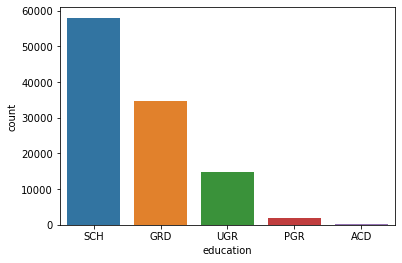

In [9]:
# посморим на распредение переменной education 
sns.countplot(x='education', data=data)


In [10]:
# так как процент пропусков меньше половины процента то мы можем заменить пропуски самым часто ичпользуемым значением
data.education.fillna('SCH', inplace=True)

In [11]:
# преобразуем признак app_date в формат даты и потом попробуем достать с нее новые признаки
data.app_date = pd.to_datetime(data.app_date)

In [12]:
# Разделим наши признаки на числовые, бинарные и категорийные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'm']

In [13]:
# Добавим новый признак - разницу в днях между первой заявкой о остальными
data_min = min(data['app_date'])
data['app_date_timedelta'] = (data['app_date'] - data_min).dt.days.astype('int')
num_cols.append('app_date_timedelta')

0.0    64427
1.0     9372
Name: default, dtype: int64

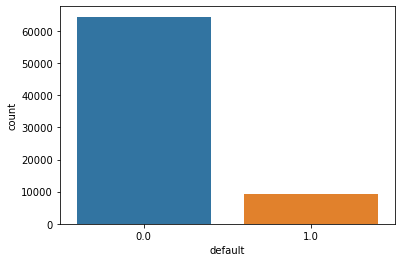

In [14]:
# посмотрим на рспередение целефой переменной
sns.countplot(x='default', data=data[data.train==1])
data[data.train==1]['default'].value_counts()

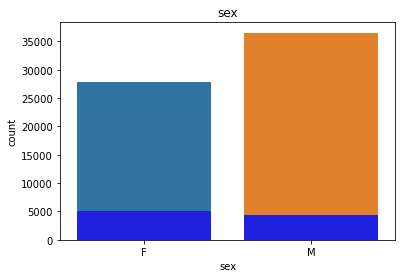

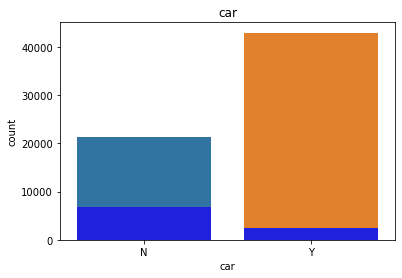

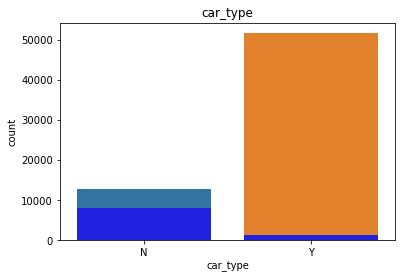

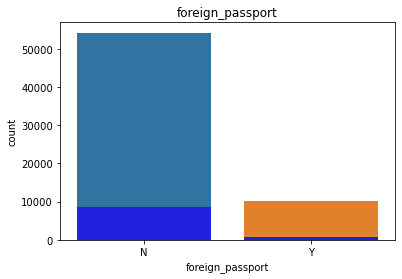

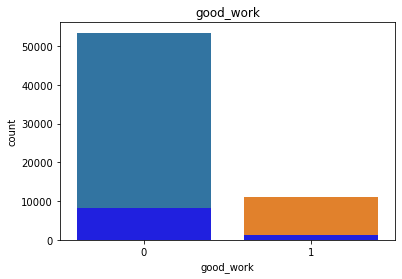

In [15]:
# посмотрим на распределение бинарных переменных
for i in bin_cols:
    plt.figure()
    sns.countplot(data[(data.train==1)&(data.default==0)][i].dropna())
    sns.countplot(data[(data.train==1)&(data.default==1)][i].dropna(), color='b')
    plt.title(i)
    plt.show()



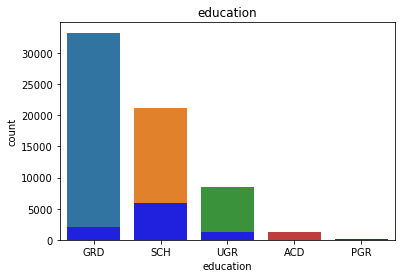

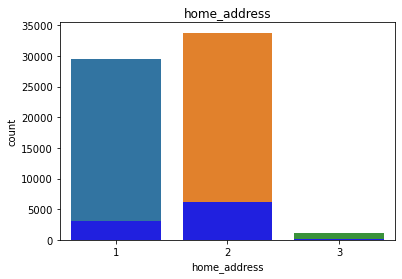

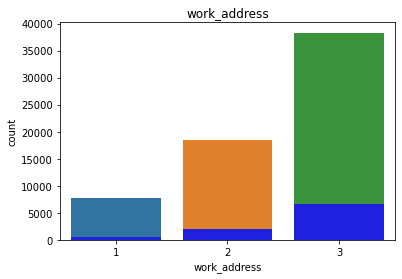

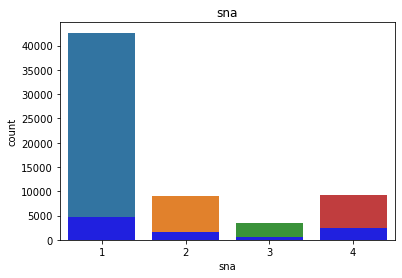

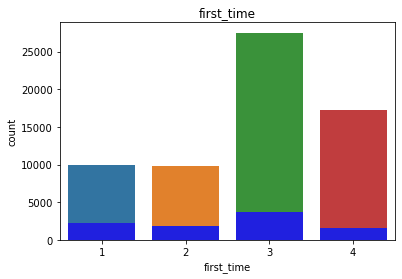

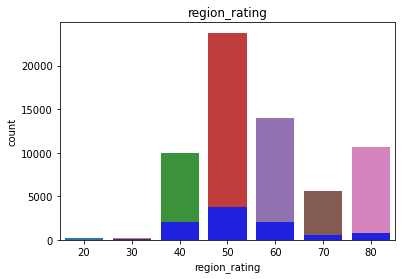

In [16]:
# посмотрим на распределение категорийных переменных
for i in cat_cols:
    plt.figure()
    sns.countplot(data[(data.train==1)&(data.default==0)][i].dropna())
    sns.countplot(data[(data.train==1)&(data.default==1)][i].dropna(), color='b')
    plt.title(i)
    plt.show()

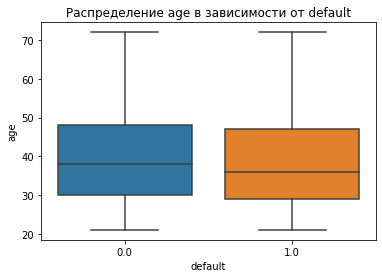

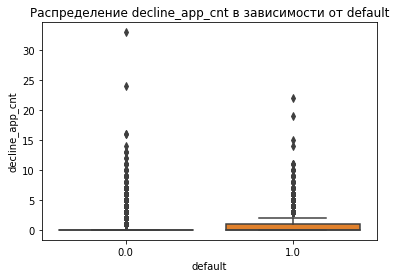

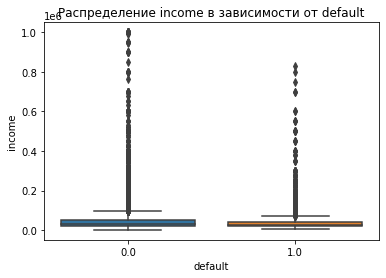

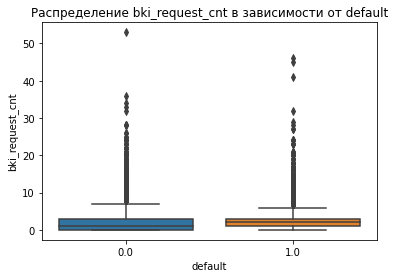

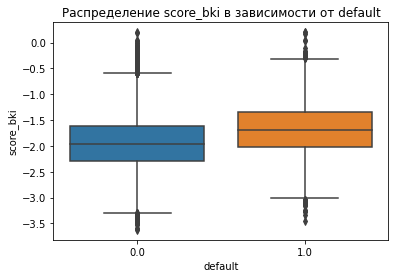

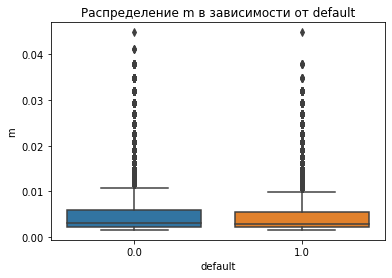

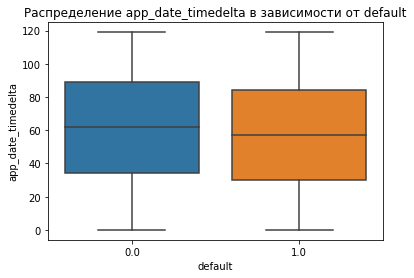

In [17]:
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col} в зависимости от default")
    sns.boxplot("default", col, data=data[data.train==1])

In [18]:
# бинарные признаки и категорийные признак education переведем в числовой формат для работы с машинным обучением
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
map_edu ={'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}
data.education = data.education.map(map_edu) 

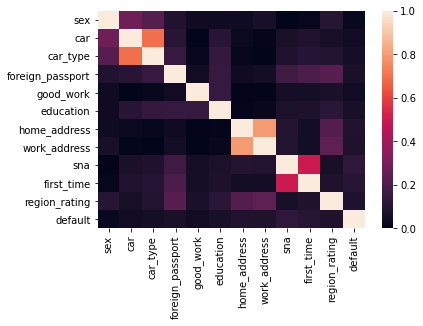

In [19]:
# посмотрим как бинарные и категорийные признаки коррелируют между собой и с целеф
sns.heatmap(data[data.train==1][bin_cols + cat_cols + ['default']].corr(method='spearman').abs(), vmin=0, vmax=1)

In [20]:
# Удалим признак 'car'
bin_cols.remove('car')


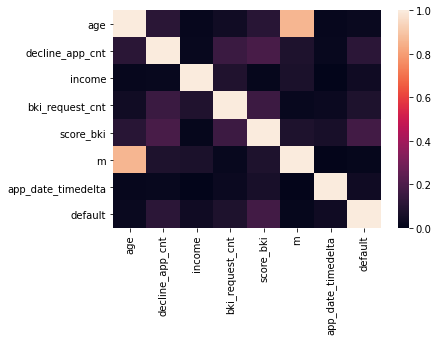

In [21]:
# посмотрим как бинарные и категорийные признаки коррелируют между собой и с целевой  переменной
sns.heatmap(data[data.train==1][num_cols + ['default']].corr().abs(), vmin=0, vmax=1)

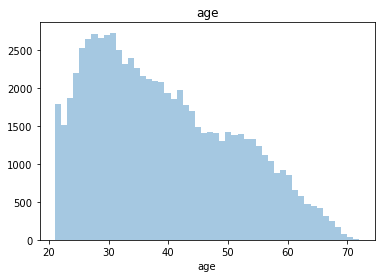

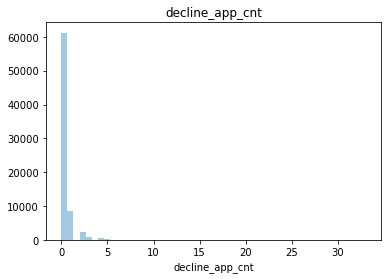

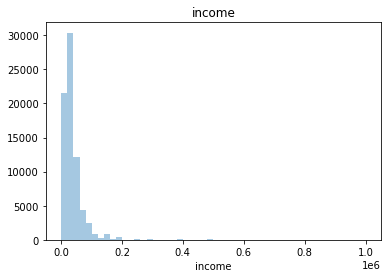

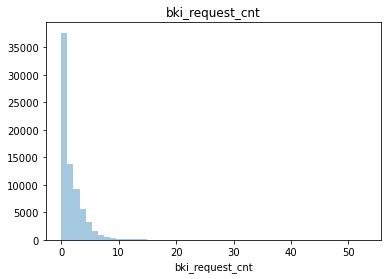

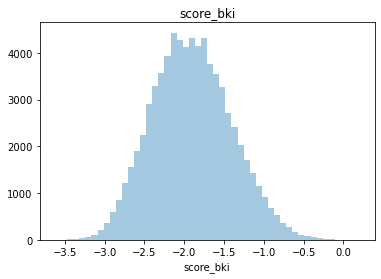

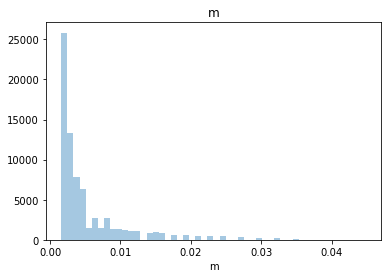

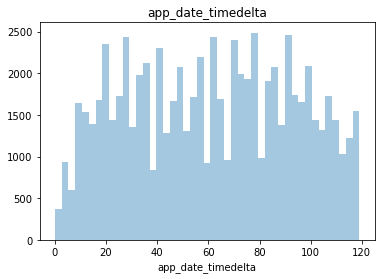

In [22]:
# посмотрим на распредение числовый признаков

for i in num_cols:
    plt.figure()
    sns.distplot(data[data.train==1][i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

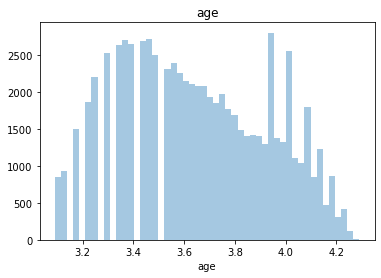

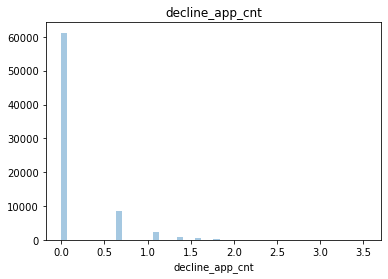

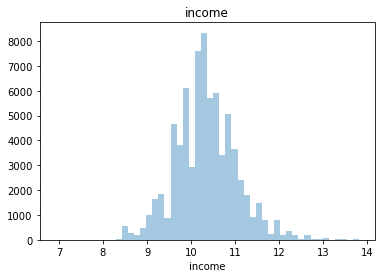

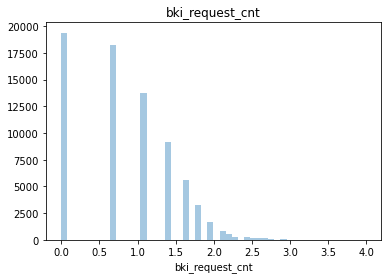

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


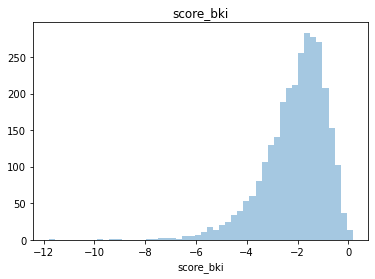

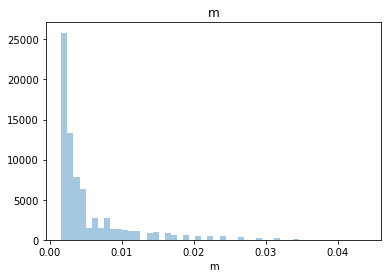

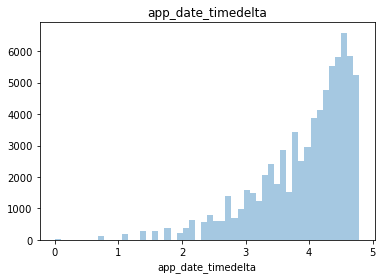

In [23]:
# признаки имеют не нормально распередение попробуем исправить это прологорефмировав их

for i in num_cols:
    plt.figure()
    sns.distplot(np.log(data[data.train==1][i] + 1), kde = False, rug=False)
    plt.title(i)
    plt.show()


In [24]:
data['income'].value_counts()

30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
          ...  
27478         1
27350         1
20412         1
23120         1
426000        1
Name: income, Length: 1207, dtype: int64

In [25]:
# Заменим признаки age, income, bki_request_cnt, decline_app_cnt их логарифмами
data['income'] = np.log(data['income']+1)
data['age'] = np.log(data['age']+1)
data.bki_request_cnt = np.log(data.bki_request_cnt+1)
data.decline_app_cnt = np.log(data.decline_app_cnt+1)

In [26]:
# Добавим признак месяца подачи заявки
data['month'] = data.app_date.dt.month
cat_cols.append('month')


In [27]:
# Превратим числовой признак в категорийный тем самым избавимся от длинного правого хвоста и выбросов
data.bki_request_cnt = data.bki_request_cnt.apply(lambda x: 0 if x == 0 else 1 if 0 < x < 1 else 2 if 1 < x < 2 else 3)
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

In [28]:
# Сгенерируем новые признаки комбинируя категорийные и числовые признаки
data['new'] = ((data.income**2)*data.region_rating)/data.age
num_cols.append('new')
data['new2'] = (data.score_bki*data.region_rating)/data.age
num_cols.append('new2')
data['new3'] = data.income**2
num_cols.append('new3')
data['new4'] = (data.age/data.first_time)*data.score_bki
num_cols.append('new4')
data['new5'] = (data.score_bki*data.sna)
num_cols.append('new5')
data['new6'] = (data.income**2)*data.sna
num_cols.append('new6')
data['new7'] = ((data.income**2)*data.first_time)/data.age
num_cols.append('new7')


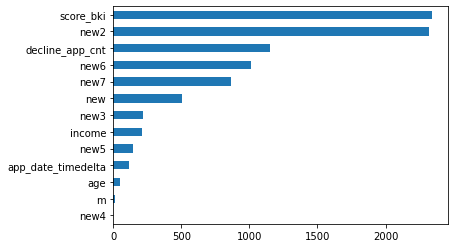

In [29]:
# посмотрим как числовые признаки влияют на целевую переменную
imp_num = Series(f_classif(data[data.train==1][num_cols], data[data.train==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


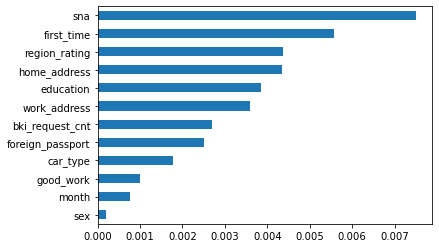

In [30]:
# посмотрим как бинарные и категорийные признаки влияют на целевую переменную
imp_cat = Series(mutual_info_classif(data[data.train==1][bin_cols + cat_cols], data[data.train==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

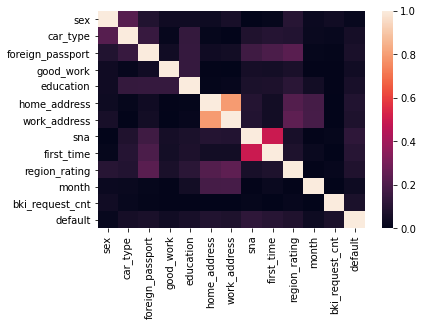

In [31]:
sns.heatmap(data[data.train==1][bin_cols + cat_cols + ['default']].corr(method='spearman').abs(), vmin=0, vmax=1)

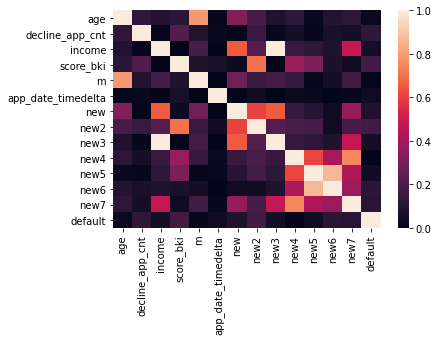

In [32]:
sns.heatmap(data[data.train==1][num_cols + ['default']].corr().abs(), vmin=0, vmax=1)

In [33]:
# Стандартизируем числовые признаки
ss = StandardScaler()
data[num_cols] = pd.DataFrame(ss.fit_transform(data[num_cols]),columns = data[num_cols].columns)

In [34]:
# Подготовим данные для машинного обучения
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_num = data[num_cols].values
X = np.hstack([X_num, data[bin_cols].values, X_cat,
               np.reshape(data['train'].values, (len(data), 1))])
Y = data[data.train == 1]['default'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X[X[:,-1] == 1][:, :-1], Y, test_size=0.20, random_state=42)

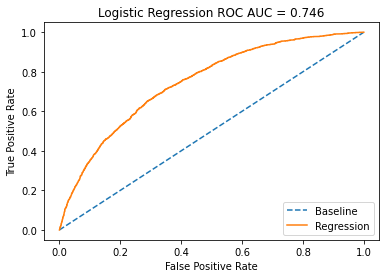

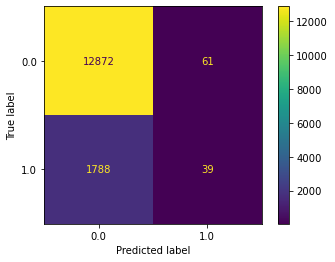

In [36]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

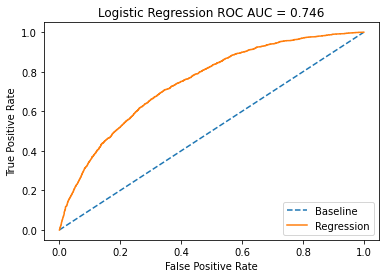

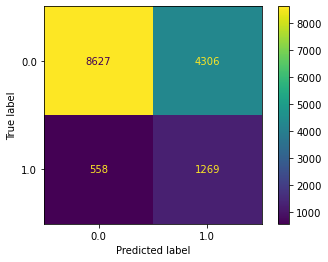

In [37]:
# Запустим обучени с заранее подобранными параметрами с помощью GridSearchCV
model = LogisticRegression(C=1, max_iter=500,
 class_weight='balanced',
 dual=False,
 fit_intercept=True,
 intercept_scaling=1,
 l1_ratio=None,
 multi_class='auto',
 n_jobs=None,
 penalty='l1',
 random_state=42,
 solver='liblinear',
 tol=0.0001,
 verbose=0,
 warm_start=False)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [38]:
# выделяем тестовый датасет из датасета data
X_test_1 = X[X[:,-1] == 0][:, :-1]


In [39]:
y = model.predict_proba(X_test_1)
y = y[:,1]

In [40]:
submit = pd.DataFrame(test_data.client_id)

In [41]:
submit['default'] = y

In [42]:
# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)